In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import os
import time
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import os
print(os.listdir("../input"))

['embeddings', 'train.csv', 'sample_submission.csv', 'test.csv']


**1. Feature and data explanation**


The basis of this project is taken kaggle competition "Quora Insincere Questions Classification".  Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.
In this competition, we will develop models that identify and flag insincere questions.
An existential problem for any major website today is how to handle toxic and divisive content. Quora wants to tackle this problem head-on to keep their platform a place where users can feel safe sharing their knowledge with the world.

In this project I will try to help them with this. Let's start!

In this competition we will be predicting whether a question asked on Quora is sincere or not.
An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:
* Has a non-neutral tone:
  *    Has an exaggerated tone to underscore a point about a group of people
  *    Is rhetorical and meant to imply a statement about a group of people
* Is disparaging or inflammatory:
  *      Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
  *      Makes disparaging attacks/insults against a specific person or group of people
  *      Based on an outlandish premise about a group of people
  *      Disparages against a characteristic that is not fixable and not measurable
* Isn't grounded in reality:
  *     Based on false information, or contains absurd assumptions
* Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers*

The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.



 * *File descriptions*  (data is here https://www.kaggle.com/c/quora-insincere-questions-classification/data)
   * train.csv - the training set
   * test.csv - the test set
   * sample_submission.csv - A sample submission in the correct format
   * embeddings/ - (see below)
   
*    *Data fields*
    * qid - unique question identifier
    * question_text - Quora question text
    * target - a question labeled "insincere" has a value of 1, otherwise 0

External data sources are not allowed for this competition. But Quora provides us with a number of pre-trained word vectors
* GoogleNews-vectors-negative300 - https://code.google.com/archive/p/word2vec/
* glove.840B.300d - https://nlp.stanford.edu/projects/glove/
* paragram_300_sl999 - https://cogcomp.org/page/resource_view/106
* wiki-news-300d-1M - https://fasttext.cc/docs/en/english-vectors.html



**2. Primary data analysis**

In [2]:
# load train and test datasets
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print("Train datasets shape:", train_df.shape)
print("Test datasets shape:", test_df.shape)
train_df.head()

Train datasets shape: (1306122, 3)
Test datasets shape: (56370, 2)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [3]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56370 entries, 0 to 56369
Data columns (total 2 columns):
qid              56370 non-null object
question_text    56370 non-null object
dtypes: object(2)
memory usage: 880.9+ KB


We can see there are no missing values

First let us look at the distribution of the target variable to understand more about the imbalance and so on.

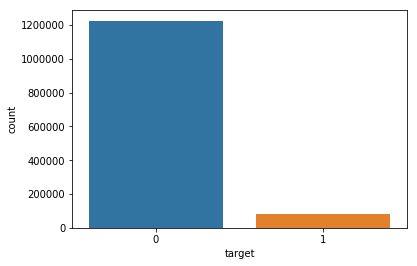

In [4]:
sns.countplot(train_df['target'])

So we see that data unbalanced.

Since we only have text data, let's take a look at some of the mean values ​​of words / sentences.

In [5]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Average word length of questions in test is {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x.split())))))

Average word length of questions in train is 13.
Average word length of questions in test is 13.


In [6]:
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x.split())))))

Max word length of questions in train is 134.
Max word length of questions in test is 87.


In [7]:
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x)))))
print('Average character length of questions in test is {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x)))))

Average character length of questions in train is 71.
Average character length of questions in test is 70.


As we can see on average questions in train and test datasets are similar, but there are quite long questions in train dataset.

Let's look at the most frequent words in each of the classes separately and immediately visualize it

In [54]:
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
train1_df = train_df[train_df["target"]==1]
train0_df = train_df[train_df["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted_0 = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted_0.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted_1 = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted_1.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



It can be seen that in insincere questions words as 'black',  'white', 'muslims', 'trump', 'woman' is predominate, which hints at us on racial discrimination, sexual content. But for example, the word 'people' is often found in both classes. Let's look at bi-gramm and tri-gramm to understand the context in which they most often used.

In [9]:
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere questions", 
                                          "Frequent bigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [10]:
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.15,
                          subplot_titles=["Frequent trigrams of sincere questions", 
                                          "Frequent trigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



On these two graphs, you can see phrases that determine the insincere question or not. They clearly indicate unfriendly content.
No wonder that the word 'donald trump' is so common. These words apparently refer to the political context, and there, as is well known, there are always heated discussions between his supporters and those who do not like him.

**3. Primary visual data analysis**

Text(0.5,1,'Distribution of question text length in characters in train')

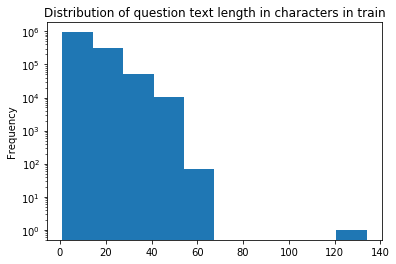

In [11]:
train_df['question_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in characters in train')

Text(0.5,1,'Distribution of question text length in characters in test')

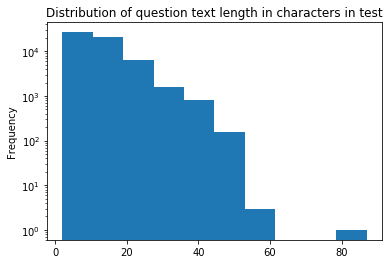

In [12]:
test_df['question_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in characters in test')

We can see that most of the questions in train and test are 40 words long or shorter. 


Now let us see how some  features are distributed between both sincere and insincere questions.

Text(0.5,1,'Number of characters in each class')

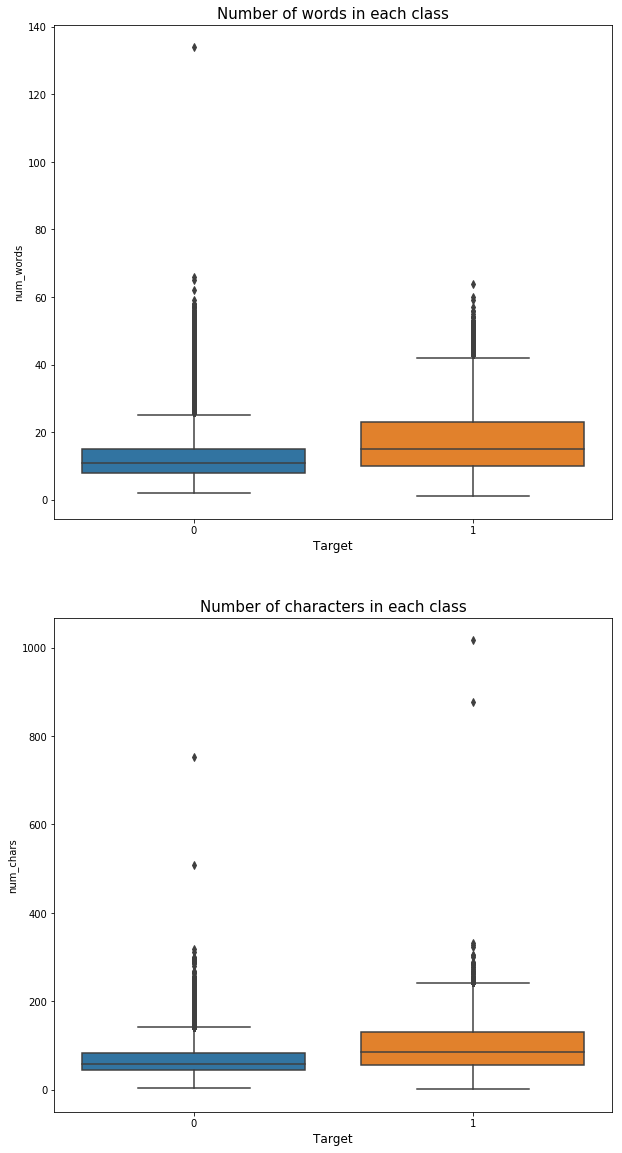

In [13]:
# ## Number of words in the text ##
train_df["num_words"] = train_df["question_text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["question_text"].apply(lambda x: len(str(x).split()))

## Number of characters in the text ##
train_df["num_chars"] = train_df["question_text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["question_text"].apply(lambda x: len(str(x)))

f, axes = plt.subplots(2, 1, figsize=(10,20))
sns.boxplot(x='target', y='num_words', data=train_df, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='num_chars', data=train_df, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

We can see that the insincere questions have more number of words as well as characters compared to sincere questions

**4. Insights and found dependencies **
The problem is closely related to sentiment analysis as well. Usually, neural networks, for example RNN / LSTM, which can reveal hidden patterns are most often used in such tasks. 
But we noticed that some word combinations, which determine the class of the question, stand out very well, let's make text preprocessing plus TFIDFTransform and try to make simple LogisticRegression baseline.

**5. Metrics selection**

Metrics -** F1 score ** is given in competition. F1  is a function of Precision and Recall. 
F1 formula:
**F1 = 2*(Precision * Recall)/(Precision + Recall)**

F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall. 
Since dataset is very unbalanced, it’s no wonder why this metric is chosen.

**6. Model selection**
We will predict the class of the question using a simple logistic regression.

**7. Data preprocessing**

Lets make some text preprocessing:
* Removing numbers and special characters
* Lowering letters
* Removing Stopwords
* Lemmatization 

In [14]:
from nltk import WordNetLemmatizer
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()
def preprocess_text(text): 
    # Keeping letters + lowerring
    text = re.sub("[^a-zA-Z]"," ", text)
    text = re.findall(r"[a-zA-Z]+", text.lower())  
    # Removing stopwords
    text = [word for word in text if (word not in stop_words and len(word)>2)]
    
    # Lemming
    text = [wnl.lemmatize(word) for word in text]
    
    # Removing repetitions
    text = re.sub(r'(.)\1+', r'\1\1', ' '.join(text))
    
    return text

print('Cleaning data ... ')
train_df['clean_text'] = train_df['question_text'].transform(preprocess_text)
test_df['clean_text'] = test_df['question_text'].transform(preprocess_text)
print(train_df['clean_text'])

Cleaning data ... 
0                     quebec nationalist see province nation
1              adopted dog would encourage people adopt shop
2          velocity affect time velocity affect space geo...
3                otto von guericke used magdeburg hemisphere
4          convert montra helicon mountain bike changing ...
5          gaza slowly becoming auschwitz dachau treblink...
6          quora automatically ban conservative opinion r...
7                    crazy wash wipe grocery germ everywhere
8          thing dressing moderately different dressing m...
9          ever phase wherein became ignorant people love...
10                                              say feminism
11                                     calgary flame founded
12         dumbest yet possibly true explanation trump el...
13         use external hard disk well data storage data ...
14         living home boyfriend would love boyfriend hom...
15                           know bram fischer rivonia trial
16   

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 3))
x_train = tfidf.fit_transform(train_df['clean_text'])
y_train = train_df['target']

print(x_train.shape)

(1306122, 8355306)


For cross-validation I will use StratifiedKFold with 5 folds, because target is unbalance

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score

skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)
logit = LogisticRegression(C=1, random_state = 7)
cv_scores = cross_val_score(logit, x_train, train_df['target'], cv=skf,
                                    scoring='f1', n_jobs=-1)
print(cv_scores.mean(), cv_scores)

0.38476906019114726 [0.38353593 0.38863566 0.38138621 0.38635455 0.38393295]


Now try to add a little bit meta feature.

In [18]:
import string
train_df["num_words"] = train_df['question_text'].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df['question_text'].apply(lambda x: len(str(x).split()))

train_df["num_unique_words"] = train_df['question_text'].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df['question_text'].apply(lambda x: len(set(str(x).split())))

train_df["num_chars"] = train_df['question_text'].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df['question_text'].apply(lambda x: len(str(x)))

train_df["mean_word_len"] = train_df['question_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df['question_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

train_df["num_stopwords"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test_df["num_stopwords"] = test_df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] =test_df["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
print(train_df.head(5))

                    qid       ...       num_words_title
0  00002165364db923c7e6       ...                     2
1  000032939017120e6e44       ...                     1
2  0000412ca6e4628ce2cf       ...                     2
3  000042bf85aa498cd78e       ...                     4
4  0000455dfa3e01eae3af       ...                     3

[5 rows x 12 columns]


In [19]:
from scipy.sparse import hstack
feats = ["num_words", "num_unique_words", "num_chars", "mean_word_len", "num_stopwords", "num_punctuations", "num_words_upper", "num_words_title"]
X_train_full = hstack([x_train, train_df[feats].values])

cv_scores = cross_val_score(logit, X_train_full, train_df['target'], cv=skf,
                                    scoring='f1', n_jobs=-1)
print(cv_scores.mean(), cv_scores)

0.44048115414359523 [0.44050568 0.44073555 0.43529462 0.44501886 0.44085106]


Now, let's find optimal parametr C for logregression using GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
 #GridSearch for C
c_values = np.linspace(10, 15, 5)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                           scoring='f1', n_jobs=-1, cv=skf, verbose=1)

logit_grid_searcher.fit(X_train_full, train_df['target'])
print(logit_grid_searcher.best_score_, logit_grid_searcher.best_params_)

C = 12.5 is the best parameter!

Now let's train our logreg again with new feature and best parameter. And we find the best treshold use our cross-validation strategy. And make predict for test

In [42]:
from scipy.sparse import coo_matrix
import operator

def f1_smart(y_true, y_proba):
    scores = {}
    for thres in np.arange(0.1, 0.51, 0.01):
        thres = round(thres, 3)
        scores[thres] = f1_score(y_true, (y_proba > thres).astype(int))
    # get max
    best_thres, best_score = max(scores.items(), key=operator.itemgetter(1))
    return best_score, best_thres
x_test = tfidf.transform(test_df['clean_text'])
X_test_full = hstack([x_test, test_df[feats].values])
best_thres = []
y_submit = np.zeros((X_test_full.shape[0], ))
X_train_full = X_train_full.tocsr()
X_test_full = X_test_full.tocsr()
splits = skf.split(X_train_full, train_df['target'])
for idx, (train_idx, valid_idx) in enumerate(splits):
        X_train = X_train_full[train_idx]
        y_train = train_df['target'][train_idx]
        X_val = X_train_full[valid_idx]
        y_val = train_df['target'][valid_idx]
        logit = LogisticRegression(C=12.5, random_state = 7)
        logit.fit(X_train, y_train)
        y_proba = logit.predict_proba(X_val)[:, 1]
        f1, threshold = f1_smart(y_val, y_proba)
        print('optimal F1: {:.4f} at threshold: {:.4f}'.format(f1, threshold))
        y_submit += logit.predict_proba(X_test_full)[:, 1] / 5

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



optimal F1: 0.6116 at threshold: 0.1900
optimal F1: 0.6112 at threshold: 0.1500
optimal F1: 0.6044 at threshold: 0.1800
optimal F1: 0.6144 at threshold: 0.1700
optimal F1: 0.6065 at threshold: 0.1600


In [ ]:
sub = pd.read_csv('../input/sample_submission.csv')
sub.prediction =  (y_submit > np.mean(best_thres)).astype(int)
sub.to_csv("submission.csv", index=False)